In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.cluster.vq import kmeans2
import torch
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import shuffle
from math import pi
from torch.utils.data import TensorDataset, DataLoader

def chol(A):
    return torch.linalg.cholesky(A)

def chol_solve(L, y):
    if y.dim() == 1:
        y = y.unsqueeze(1)
    
    z = torch.linalg.solve_triangular(L, y, upper=False)
    x = torch.linalg.solve_triangular(L.T, z, upper=True)
    
    if y.shape[1] == 1:
        return x.squeeze(1)
    return x

def logDet(L):
    return 2 * torch.sum(torch.log(torch.diag(L)))

class GaussianProcess:
    def __init__(self, n_restarts_optimizer=10):
        self.n_restarts_optimizer = n_restarts_optimizer
        self.constant_value_opt = None    
        self.length_scale_opt = None      
        self.noise_level_opt = None      
        self.X_train = None
        self.y_train = None
        self.L = None
        self.alpha = None
        
    def kernel_function(self, X1, X2, constant_value, length_scale, noise_level=0.0, eval_gradient=False):
        # RBF kernel with sklearn-like parameterization
        X1_sq = np.sum(X1**2, axis=1, keepdims=True)
        X2_sq = np.sum(X2**2, axis=1)
        sqdist = X1_sq + X2_sq - 2 * np.dot(X1, X2.T)
        rbf = np.exp(-0.5 * sqdist / (length_scale**2))
        K = constant_value * rbf
        if X1 is X2 or np.array_equal(X1, X2):
            K = K + noise_level * np.eye(X1.shape[0])     
        return K
    
    def log_marginal_likelihood(self, params, X, y):
        constant_value, length_scale, noise_level = params
        constant_value = np.exp(constant_value)
        length_scale = np.exp(length_scale)
        noise_level = np.exp(noise_level)
        
        K = self.kernel_function(X, X, constant_value, length_scale, noise_level)
        
        try:
            L = np.linalg.cholesky(K)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            log_det = 2 * np.sum(np.log(np.diag(L)))
            nll = 0.5 * y.T @ alpha + 0.5 * log_det + 0.5 * len(X) * np.log(2 * np.pi)
            return nll
        except np.linalg.LinAlgError:
            return 1e10  
    
    def fit(self, X, y):
        self.X_train = X.reshape(-1, 1) if X.ndim == 1 else X
        self.y_train = y.ravel() if y.ndim > 1 else y

        if self.constant_value_opt is None:
            self.constant_value_opt = 1.0
        if self.length_scale_opt is None:
            self.length_scale_opt = 1.0
        if self.noise_level_opt is None:
            self.noise_level_opt = 0.1
            
        initial_params = [np.log(1.0), np.log(1.0), np.log(0.1)]
        bounds = [(np.log(0.1), np.log(10.0)),    
                  (np.log(0.1), np.log(10.0)),   
                  (np.log(1e-5), np.log(1.0))]   
        
        best_params = initial_params
        best_nll = float('inf')
        
        for i in range(self.n_restarts_optimizer):
            init_constant = np.random.uniform(np.log(0.1), np.log(10.0))
            init_lengthscale = np.random.uniform(np.log(0.1), np.log(10.0))
            init_noise = np.random.uniform(np.log(1e-5), np.log(1.0))
            
            result = minimize(
                self.log_marginal_likelihood,
                [init_constant, init_lengthscale, init_noise],
                args=(self.X_train, self.y_train),
                bounds=bounds,
                method='L-BFGS-B',
                options={'maxiter': 1000, 'ftol': 1e-6}
            )
            
            if result.success and result.fun < best_nll:
                best_nll = result.fun
                best_params = result.x
        
        log_constant, log_length_scale, log_noise = best_params
        self.constant_value_opt = np.exp(log_constant)     
        self.length_scale_opt = np.exp(log_length_scale)   
        self.noise_level_opt = np.exp(log_noise)          
        
        K = self.kernel_function(self.X_train, self.X_train, 
                                self.constant_value_opt, 
                                self.length_scale_opt, 
                                self.noise_level_opt)
        
        self.L = np.linalg.cholesky(K)
        self.alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.y_train))
        return self
    
    def predict(self, X_pred, return_std=True):
        X_pred = X_pred.reshape(-1, 1) if X_pred.ndim == 1 else X_pred
        K_s = self.kernel_function(self.X_train, X_pred, 
                                  self.constant_value_opt, 
                                  self.length_scale_opt, 
                                  noise_level=0.0)  
        mu = K_s.T @ self.alpha
        if return_std:
            v = np.linalg.solve(self.L, K_s)
            K_ss = self.kernel_function(X_pred, X_pred, 
                                       self.constant_value_opt, 
                                       self.length_scale_opt,
                                       noise_level=0.0)
            cov = K_ss - v.T @ v
            std = np.sqrt(np.maximum(np.diag(cov), 0))
            return mu.ravel(), std
        else:
            return mu.ravel()


class SparseGPBase(GaussianProcess):
    def __init__(self, n_restarts_optimizer=10, n_inducing=4):
        super().__init__(n_restarts_optimizer)
        self.n_inducing = n_inducing
        self.Z = None  
        self.K_MM_inv = None
        self.K_MN = None
        self.K_NM = None
        self.inducing_indices = None 
        
    def select_inducing_points(self, X, method='kmeans'):
        n = X.shape[0]
        
        if self.n_inducing >= n:
            self.Z = X.copy()
            self.inducing_indices = list(range(n))
        else:
            if method == 'kmeans':
                centroids, labels = kmeans2(X, self.n_inducing, minit='points')
                self.Z = centroids
                self.inducing_indices = None  
            elif method == 'random':
                self.inducing_indices = np.random.choice(n, self.n_inducing, replace=False)
                self.Z = X[self.inducing_indices].copy()
            elif method == 'uniform':
                idx = np.linspace(0, n-1, self.n_inducing).astype(int)
                self.inducing_indices = idx
                self.Z = X[idx].copy()
            else:
                raise ValueError(f"Unknown method: {method}")
        return self.Z
    
    def compute_kernel_matrices(self, X, Z):
        if self.constant_value_opt is None:
            self.constant_value_opt = 1.0
        if self.length_scale_opt is None:
            self.length_scale_opt = 1.0
            
        self.K_MM = self.kernel_function(Z, Z, self.constant_value_opt, 
                                        self.length_scale_opt, noise_level=0.0)
        self.K_NM = self.kernel_function(X, Z, self.constant_value_opt, 
                                        self.length_scale_opt, noise_level=0.0)
        self.K_MN = self.K_NM.T
        self.K_MM_inv = np.linalg.inv(self.K_MM + 1e-8 * np.eye(self.K_MM.shape[0]))
        return self.K_MM, self.K_NM, self.K_MN
    
    def _optimize_hyperparameters(self, X, y):
        initial_params = [np.log(1.0), np.log(1.0), np.log(0.1)]
        bounds = [(np.log(0.1), np.log(10.0)),    
                  (np.log(0.1), np.log(10.0)),   
                  (np.log(1e-5), np.log(1.0))]   
        
        best_params = initial_params
        best_nll = float('inf')
        
        for i in range(self.n_restarts_optimizer):
            init_constant = np.random.uniform(np.log(0.1), np.log(10.0))
            init_lengthscale = np.random.uniform(np.log(0.1), np.log(10.0))
            init_noise = np.random.uniform(np.log(1e-5), np.log(1.0))
            
            result = minimize(
                self.log_marginal_likelihood,
                [init_constant, init_lengthscale, init_noise],
                args=(X, y),
                bounds=bounds,
                method='L-BFGS-B',
                options={'maxiter': 1000, 'ftol': 1e-6}
            )
            
            if result.success and result.fun < best_nll:
                best_nll = result.fun
                best_params = result.x
        
        log_constant, log_length_scale, log_noise = best_params
        self.constant_value_opt = np.exp(log_constant)     
        self.length_scale_opt = np.exp(log_length_scale)   
        self.noise_level_opt = np.exp(log_noise)          
        
        return self.constant_value_opt, self.length_scale_opt, self.noise_level_opt


class SoRGP(SparseGPBase):
    def fit(self, X, y):
        self.X_train = X.reshape(-1,1) if X.ndim==1 else X
        self.y_train = y.ravel() if y.ndim>1 else y
        self.Z = self.select_inducing_points(self.X_train, method='kmeans')
        self._optimize_hyperparameters(self.X_train, self.y_train)
        self.compute_kernel_matrices(self.X_train, self.Z)
        self.sigma2 = self.noise_level_opt
        self.K_MM_inv_K_MN = self.K_MM_inv @ self.K_MN  
        self.Q_NN = self.K_NM @ self.K_MM_inv_K_MN  
        B = self.sigma2 * np.eye(self.X_train.shape[0]) + self.Q_NN
        # Woodbury identity
        inv = np.linalg.inv(self.K_MM + (1/self.sigma2) * self.K_MN @ self.K_NM)
        self.B_inv = (1/self.sigma2) * np.eye(B.shape[0]) - (1/self.sigma2)**2 * self.K_NM @ inv @ self.K_MN
        self.alpha = self.K_MM_inv_K_MN @ self.B_inv @ self.y_train
        return self

    def predict(self, X_pred, return_std=True):
        X_pred = X_pred.reshape(-1,1) if X_pred.ndim==1 else X_pred
        K_sM = self.kernel_function(X_pred, self.Z, self.constant_value_opt, self.length_scale_opt)
        mu = K_sM @ self.alpha
        
        if return_std:
            Q_ss = K_sM @ self.K_MM_inv @ K_sM.T
            Q_ss_diag = np.diag(Q_ss)
            K_sM_K_MM_inv = K_sM @ self.K_MM_inv
            Q_sN = K_sM_K_MM_inv @ self.K_MN
            var = Q_ss_diag - np.sum(Q_sN @ self.B_inv * Q_sN, axis=1)
            return mu.ravel(), np.sqrt(np.maximum(var, 0))
        else:
            return mu.ravel()


class DTCGP(SparseGPBase):
    def fit(self, X, y):
        self.X_train = X.reshape(-1,1) if X.ndim==1 else X
        self.y_train = y.ravel() if y.ndim>1 else y
        self.Z = self.select_inducing_points(self.X_train, method='kmeans')
        self._optimize_hyperparameters(self.X_train, self.y_train)
        self.compute_kernel_matrices(self.X_train, self.Z)
        self.sigma2 = self.noise_level_opt
        self.K_MM_inv_K_MN = self.K_MM_inv @ self.K_MN  
        self.Q_NN = self.K_NM @ self.K_MM_inv_K_MN  
        B = self.sigma2 * np.eye(self.X_train.shape[0]) + self.Q_NN
        # Woodbury identity
        inv = np.linalg.inv(self.K_MM + (1/self.sigma2) * self.K_MN @ self.K_NM)
        self.B_inv = (1/self.sigma2) * np.eye(B.shape[0]) - (1/self.sigma2)**2 * self.K_NM @ inv @ self.K_MN
        self.alpha = self.K_MM_inv_K_MN @ self.B_inv @ self.y_train
        return self
        
    def predict(self, X_pred, return_std=True):
        X_pred = X_pred.reshape(-1,1) if X_pred.ndim==1 else X_pred
        K_sM = self.kernel_function(X_pred, self.Z, self.constant_value_opt, self.length_scale_opt)
        mu = K_sM @ self.alpha
        
        if return_std:
            K_sM_K_MM_inv = K_sM @ self.K_MM_inv
            Q_sN = K_sM_K_MM_inv @ self.K_MN
            K_ss_diag = np.diag(self.kernel_function(X_pred, X_pred,
                                self.constant_value_opt,
                                self.length_scale_opt))
            var = K_ss_diag - np.sum(Q_sN @ self.B_inv * Q_sN, axis=1)
            return mu.ravel(), np.sqrt(np.maximum(var, 0))
        else:
            return mu.ravel()


class FITCGP(SparseGPBase):
    def fit(self, X, y):
        self.X_train = X.reshape(-1,1) if X.ndim==1 else X
        self.y_train = y.ravel() if y.ndim>1 else y
        self.Z = self.select_inducing_points(self.X_train, method='kmeans')
        self._optimize_hyperparameters(self.X_train, self.y_train)
        self.compute_kernel_matrices(self.X_train, self.Z)
        sigma2 = self.noise_level_opt
        self.K_MM_inv_K_MN = self.K_MM_inv @ self.K_MN  
        self.Q_NN = self.K_NM @ self.K_MM_inv_K_MN
        diag_K = np.diag(self.kernel_function(self.X_train, self.X_train, 
                                             self.constant_value_opt, 
                                             self.length_scale_opt))
        D = diag_K - np.diag(self.Q_NN) + sigma2 * np.ones(self.X_train.shape[0])
        self.D_inv = np.diag(1.0 / D)
        # Woodbury
        self.B_inv = self.D_inv - self.D_inv @ self.K_NM @ np.linalg.inv(
            self.K_MM + self.K_MN @ self.D_inv @ self.K_NM) @ self.K_MN @ self.D_inv 
        self.alpha = self.K_MM_inv_K_MN @ self.B_inv @ self.y_train
        return self

    def predict(self, X_pred, return_std=True):
        X_pred = X_pred.reshape(-1,1) if X_pred.ndim==1 else X_pred
        K_sM = self.kernel_function(X_pred, self.Z, self.constant_value_opt, self.length_scale_opt)
        K_sN = self.kernel_function(X_pred, self.X_train, self.constant_value_opt, self.length_scale_opt)
        mu = K_sN @ self.B_inv @ self.y_train
        if return_std:
            K_ss_diag = np.diag(self.kernel_function(X_pred, X_pred,
                                                   self.constant_value_opt,
                                                   self.length_scale_opt))
            K_sM_K_MM_inv = K_sM @ self.K_MM_inv
            Q_sN = K_sM_K_MM_inv @ self.K_MN
            var = K_ss_diag - np.sum(Q_sN @ self.B_inv * Q_sN, axis=1)
            return mu.ravel(), np.sqrt(np.maximum(var, 0))
        else:
            return mu.ravel()

class VFE:
    def __init__(self, train_x, train_y, conf):
        self.m = min(train_x.shape[0], conf.get('num_inducing', 200))
        self.debug = conf.get('debug', False)
        self.num_epoch = conf.get('num_epoch', 100)
        self.kmeans = conf.get('kmeans', True)
        self.lr = conf.get('lr', 0.005)
        self.rv = conf.get('rv', 1.0)
        self.rl = conf.get('rl', 1.0)
        self.jitter_u = conf.get('jitter_u', 1e-6)
        self.num_train = train_x.shape[0]
        self.dim = train_x.shape[1]
        self.x = train_x.clone()
        self.y = train_y.clone()
        self.xmean, self.xstd = self.x.mean(dim=0), self.x.std(dim=0)
        self.ymean, self.ystd = self.y.mean(dim=0), self.y.std(dim=0)
        self.x = (self.x - self.xmean) / self.xstd
        self.y = (self.y - self.ymean) / self.ystd
        self.Z_numpy = None  
    
    def cov(self, X1, X2):
        sf2 = torch.exp(2 * self.log_sf)
        lscales = 1e-9 + torch.exp(self.log_lscales)
        x = X1 / lscales
        y = X2 / lscales
        x_norm = (x**2).sum(1).view(-1, 1)
        y_norm = (y**2).sum(1).view(1, -1)
        dist = (x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))).clamp(min=0)
        return sf2 * torch.exp(-0.5 * dist)

    def init_hyper(self):
        self.log_sf = torch.log(torch.tensor(self.rv)).double()
        self.log_sn = torch.log(torch.tensor(1e-3)).double()
        self.log_lscales = torch.log(self.rl * torch.ones(self.dim)).double()
        if self.kmeans:
            self.u = self.kmeans_init()
        else:
            self.u = torch.tensor(shuffle(self.x.numpy(), n_samples=self.m))
    
    def hyper_requires_grad(self, req_grad=True):
        self.log_sf.requires_grad = req_grad
        self.log_sn.requires_grad = req_grad
        self.log_lscales.requires_grad = req_grad
        self.u.requires_grad = req_grad

    def kmeans_init(self):
        return torch.tensor(MiniBatchKMeans(n_clusters=self.m).fit(self.x.numpy()).cluster_centers_)

    def loss(self, X, y):
        num_x = X.shape[0]
        sf2 = torch.exp(2 * self.log_sf)
        sn2 = torch.exp(2 * self.log_sn)
        Kuu = self.cov(self.u, self.u) + self.jitter_u * torch.eye(self.m)
        Kux = self.cov(self.u, X)
        Kxu = Kux.t()
        Luu = chol(Kuu)
        A = sn2 * Kuu + Kux.mm(Kxu)
        LA = chol(A)
        Kuxy = Kux.mv(y)

        loss_1 = -0.5 * (y.dot(y) - Kuxy.dot(chol_solve(LA, Kuxy.unsqueeze(1)).squeeze())) / sn2
        log_det_K = (num_x - self.m) * torch.log(sn2) + logDet(LA) - logDet(Luu)
        loss_2 = -0.5 * (log_det_K + num_x * torch.log(torch.tensor(2 * pi)))
        loss_3 = -0.5 * (sf2 * num_x - torch.sum(Kxu * chol_solve(Luu, Kux).t())) / sn2
        loss = loss_1 + loss_2 + loss_3
        
        return -1 * loss

    def train(self):
        self.init_hyper()
        self.hyper_requires_grad(True)
        optimizer = torch.optim.Adam([self.log_sf, self.log_lscales, self.log_sn, self.u], lr=self.lr)
        try:
            for step in range(self.num_epoch):
                optimizer.zero_grad()
                loss = self.loss(self.x, self.y)
                loss.backward()
                optimizer.step()
                #if step % 20 == 0 and self.debug:
                    #print(f'Epoch {step}, loss = {loss.item():.4f}')
        except RuntimeError as e:
            if self.debug:
                print(f"Training error: {e}")
        
        self.post_train()

    def post_train(self):
        self.hyper_requires_grad(False)
        sn2 = torch.exp(2 * self.log_sn)
        Kuu = self.cov(self.u, self.u) + self.jitter_u * torch.eye(self.m)
        Kux = self.cov(self.u, self.x)
        Kxu = Kux.t()
        Luu = chol(Kuu)
        S = Kuu + Kux.mm(Kxu) / sn2
        LS = chol(S)
        self.sf2 = torch.exp(2 * self.log_sf)
        self.sn2 = sn2
        self.mu = Kuu.mv(chol_solve(LS, Kux.mv(self.y).unsqueeze(1)).squeeze()) / sn2
        self.A = Kuu.mm(chol_solve(LS, Kuu))
        self.Luu = Luu
        self.alpha = chol_solve(Luu, self.mu.view(-1, 1)).squeeze()
        self.Z_numpy = self.u.detach().numpy()
        
    def predict(self, x, return_std=True):
        if x.dim() == 1:
            x = x.reshape(1, -1)
        
        tx = (x - self.xmean) / self.xstd
        Kxu = self.cov(tx, self.u) 
        
        py = self.ymean + self.ystd * Kxu.mv(self.alpha)
        
        if return_std:
            Kux = Kxu.t()
            invKuu_Kux = chol_solve(self.Luu, Kux)
            k_ss = self.sf2 * torch.ones(tx.shape[0])  
            Q_ss = (Kxu * invKuu_Kux.t()).sum(dim=1) 
            Q_su_invSigma_Qu_s = (invKuu_Kux.t() * (self.A @ invKuu_Kux).t()).sum(dim=1)
            var = k_ss - Q_ss + Q_su_invSigma_Qu_s
            ps2 = self.ystd**2 * (var + self.sn2)
            ps2 = ps2.clamp(min=self.ystd**2 * self.sn2)
            return py, ps2
        else:
            return py


class SVIGP(VFE):
    def __init__(self, train_x, train_y, conf):
        super(SVIGP, self).__init__(train_x, train_y, conf)
        self.batch_size = conf.get('batch_size', 128)
        self.fix_u = conf.get('fix_u', False)
        self.lr_cov = conf.get('lr_cov', self.lr)
        self.lr_u = conf.get('lr_u', self.lr)
        self.lr_qm = conf.get('lr_qm', self.lr)
        self.lr_qL = conf.get('lr_qL', self.lr)
        self.rprop_epoch = conf.get('rprop_epoch', 0)

    def optimal_q(self, n_samples=1000):
        n_samples = min(self.num_train, n_samples)
        idxs = torch.randperm(self.num_train)[:n_samples]
        sn2 = torch.exp(2 * self.log_sn)
        Kuu = self.cov(self.u, self.u) + self.jitter_u * torch.eye(self.m)
        Kux = self.cov(self.u, self.x[idxs])
        Kxu = Kux.t()
        Luu = chol(Kuu)
        invSigma = Kuu + Kux.mm(Kxu) / sn2
        LinvSigma = chol(invSigma)
        S = Kuu.mm(chol_solve(LinvSigma, Kuu))
        m = Kuu.mv(chol_solve(LinvSigma, Kux.mv(self.y[idxs]).unsqueeze(1)).squeeze()) / sn2
        return m, S

    def init_hyper(self):
        super(SVIGP, self).init_hyper()
        m, S = self.optimal_q()
        self.qm = m
        self.qL = S.tril()

    def hyper_requires_grad(self, req_grad=True):
        super(SVIGP, self).hyper_requires_grad(req_grad)
        self.qm.requires_grad = req_grad
        self.qL.requires_grad = req_grad
        if self.fix_u:
            self.u.requires_grad = False

    def loss(self, X, y):
        num_x = X.shape[0]
        sn2 = torch.exp(2 * self.log_sn)
        sf2 = torch.exp(2 * self.log_sf)
        Kuu = self.cov(self.u, self.u) + self.jitter_u * torch.eye(self.m)
        S = self.qL.tril().mm(self.qL.tril().t()) + self.jitter_u * torch.eye(self.m)
        Kux = self.cov(self.u, X)
        Kxu = Kux.t()
        Luu = chol(Kuu)
        LS = chol(S)
        invKuu_Kux = chol_solve(Luu, Kux)
        invKuu_m = chol_solve(Luu, self.qm.unsqueeze(1)).squeeze()

        mu = Kxu.mv(invKuu_m)
        K_ii = sf2 - (Kxu * invKuu_Kux.t()).sum(dim=1)

        loss_1 = -0.5 * num_x * torch.log(2 * pi * sn2) - 0.5 * (y - mu).dot(y - mu) / sn2
        loss_2 = -0.5 * K_ii.sum() / sn2
        loss_3 = -0.5 * (invKuu_Kux.t() * S.mm(invKuu_Kux).t()).sum() / sn2
        loss_4 = -0.5 * (chol_solve(Luu, S).trace() + self.qm.dot(invKuu_m) - self.m - logDet(LS) + logDet(Luu))
        loss = self.num_train * (loss_1 + loss_2 + loss_3) / num_x + loss_4
        return -1 * loss

    def set_optimizer(self):
        if self.fix_u:
            self.opt = torch.optim.Adam([
                {'params': [self.log_sf, self.log_sn, self.log_lscales], 'lr': self.lr_cov}, 
                {'params': [self.qm], 'lr': self.lr_qm}, 
                {'params': [self.qL], 'lr': self.lr_qL}])
        else:
            self.opt = torch.optim.Adam([
                {'params': [self.log_sf, self.log_sn, self.log_lscales], 'lr': self.lr_cov}, 
                {'params': [self.u], 'lr': self.lr_u}, 
                {'params': [self.qm], 'lr': self.lr_qm}, 
                {'params': [self.qL], 'lr': self.lr_qL}])

    def train(self):
        self.init_hyper()
        self.hyper_requires_grad(True)
        self.set_optimizer()

        try:
            dataset = TensorDataset(self.x, self.y)
            loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
            
            for epoch in range(self.num_epoch):
                epoch_loss = 0
                for x_batch, y_batch in loader:
                    self.opt.zero_grad()
                    loss = self.loss(x_batch, y_batch)
                    loss.backward()
                    self.opt.step()
                    epoch_loss += loss.item()
                #if epoch % 20 == 0 and self.debug:
                    #print(f"Adam Epoch {epoch}, loss = {epoch_loss/len(loader):.4f}")
        except RuntimeError as e:
            if self.debug:
                print(f"Training error: {e}")
        self.post_train()

    def post_train(self):
        self.hyper_requires_grad(False)
        sn2 = torch.exp(2 * self.log_sn)
        Kuu = self.cov(self.u, self.u) + self.jitter_u * torch.eye(self.m)
        Luu = chol(Kuu)
        Lq = self.qL.tril()
        self.sf2 = torch.exp(2 * self.log_sf)
        self.sn2 = sn2
        self.mu = self.qm
        self.Sigma = Lq.mm(Lq.t()) + self.jitter_u * torch.eye(self.m)
        
        self.Luu = Luu
        self.alpha = chol_solve(Luu, self.mu)
        self.Z_numpy = self.u.detach().numpy()
        
    def predict(self, x, return_std=True):
        if x.dim() == 1:
            x = x.reshape(1, -1)
        
        tx = (x - self.xmean) / self.xstd
        Kxu = self.cov(tx, self.u)  
        Kux = Kxu.t()  
        invKuu_m = chol_solve(self.Luu, self.mu.unsqueeze(1)).squeeze()
        py = self.ymean + self.ystd * Kxu.mv(invKuu_m)
        
        if return_std:
            invKuu_Kux = chol_solve(self.Luu, Kux) 
            k_ss = self.sf2 * torch.ones(tx.shape[0])
            Q_ss = (Kxu * invKuu_Kux.t()).sum(dim=1)
            invKuu_Sigma_invKuu = chol_solve(self.Luu, self.Sigma)
            invKuu_Sigma_invKuu = chol_solve(self.Luu, invKuu_Sigma_invKuu.t()).t()
            term3 = (Kxu * (invKuu_Sigma_invKuu @ Kux).t()).sum(dim=1)
            var = k_ss - Q_ss + term3 + self.sn2
            ps2 = self.ystd**2 * var
            ps2 = ps2.clamp(min=self.ystd**2 * self.sn2)
            return py, ps2
        else:
            return py


class VFEWrapper:
    def __init__(self, n_restarts_optimizer=5, n_inducing=10):
        self.n_inducing = n_inducing
        self.model = None
        
    def fit(self, X, y):
        train_x = torch.from_numpy(X).double()
        train_y = torch.from_numpy(y).double().view(-1)
        
        conf = {
            'num_inducing': self.n_inducing,
            'num_epoch': 50,
            'kmeans': True,
            'lr': 0.01,
            'debug': False
        }
        
        self.model = VFE(train_x, train_y, conf)
        self.model.train()
        return self
    
    def predict(self, X_pred, return_std=True):
        X_pred_tensor = torch.from_numpy(X_pred).double()
        if X_pred_tensor.dim() == 1:
            X_pred_tensor = X_pred_tensor.unsqueeze(-1)
        
        with torch.no_grad():
            py, ps2 = self.model.predict(X_pred_tensor, return_std=return_std)
        
        if return_std:
            y_pred = py.detach().numpy()
            y_std = torch.sqrt(ps2).detach().numpy()
            return y_pred, y_std
        else:
            return py.detach().numpy()
    
    def get_inducing_points(self):
        if self.model and hasattr(self.model, 'Z_numpy'):
            return self.model.Z_numpy
        return None
    
    @property
    def Z(self):
        return self.get_inducing_points()


class SVIGPWrapper:
    def __init__(self, n_restarts_optimizer=5, n_inducing=10):
        self.n_inducing = n_inducing
        self.model = None
        
    def fit(self, X, y):
        train_x = torch.from_numpy(X).double()
        train_y = torch.from_numpy(y).double().view(-1)
        
        conf = {
            'num_inducing': self.n_inducing,
            'num_epoch': 40,
            'kmeans': True,
            'lr': 0.01,
            'batch_size': 32,
            'debug': False,
            'fix_u': False,
            'rprop_epoch': 0
        }
        
        self.model = SVIGP(train_x, train_y, conf)
        self.model.train()
        return self
    
    def predict(self, X_pred, return_std=True):
        X_pred_tensor = torch.from_numpy(X_pred).double()
        if X_pred_tensor.dim() == 1:
            X_pred_tensor = X_pred_tensor.unsqueeze(-1)
        with torch.no_grad():
            py, ps2 = self.model.predict(X_pred_tensor, return_std=return_std)
        
        if return_std:
            y_pred = py.detach().numpy()
            y_std = torch.sqrt(ps2).detach().numpy()
            return y_pred, y_std
        else:
            return py.detach().numpy()
    
    def get_inducing_points(self):
        if self.model and hasattr(self.model, 'Z_numpy'):
            return self.model.Z_numpy
        return None
    
    @property
    def Z(self):
        return self.get_inducing_points()

/home/hechu/anaconda3/envs/credit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEMONSTRATION: Gaussian Process Methods Comparison

Training Full GP (N=100)...
  Prediction time: 0.01 seconds
  Mean std: 0.2038

Training SoR (M=10)...
  Prediction time: 0.01 seconds
  Mean std: 0.0982

Training DTC (M=10)...
  Prediction time: 0.01 seconds
  Mean std: 0.2562

Training FITC (M=10)...
  Prediction time: 0.00 seconds
  Mean std: 0.2527

Training VFE (M=10)...


/home/hechu/anaconda3/envs/credit/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  Prediction time: 0.00 seconds
  Mean std: 0.0693

Training SVGP (M=10)...


/home/hechu/anaconda3/envs/credit/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  Prediction time: 0.00 seconds
  Mean std: 0.0291


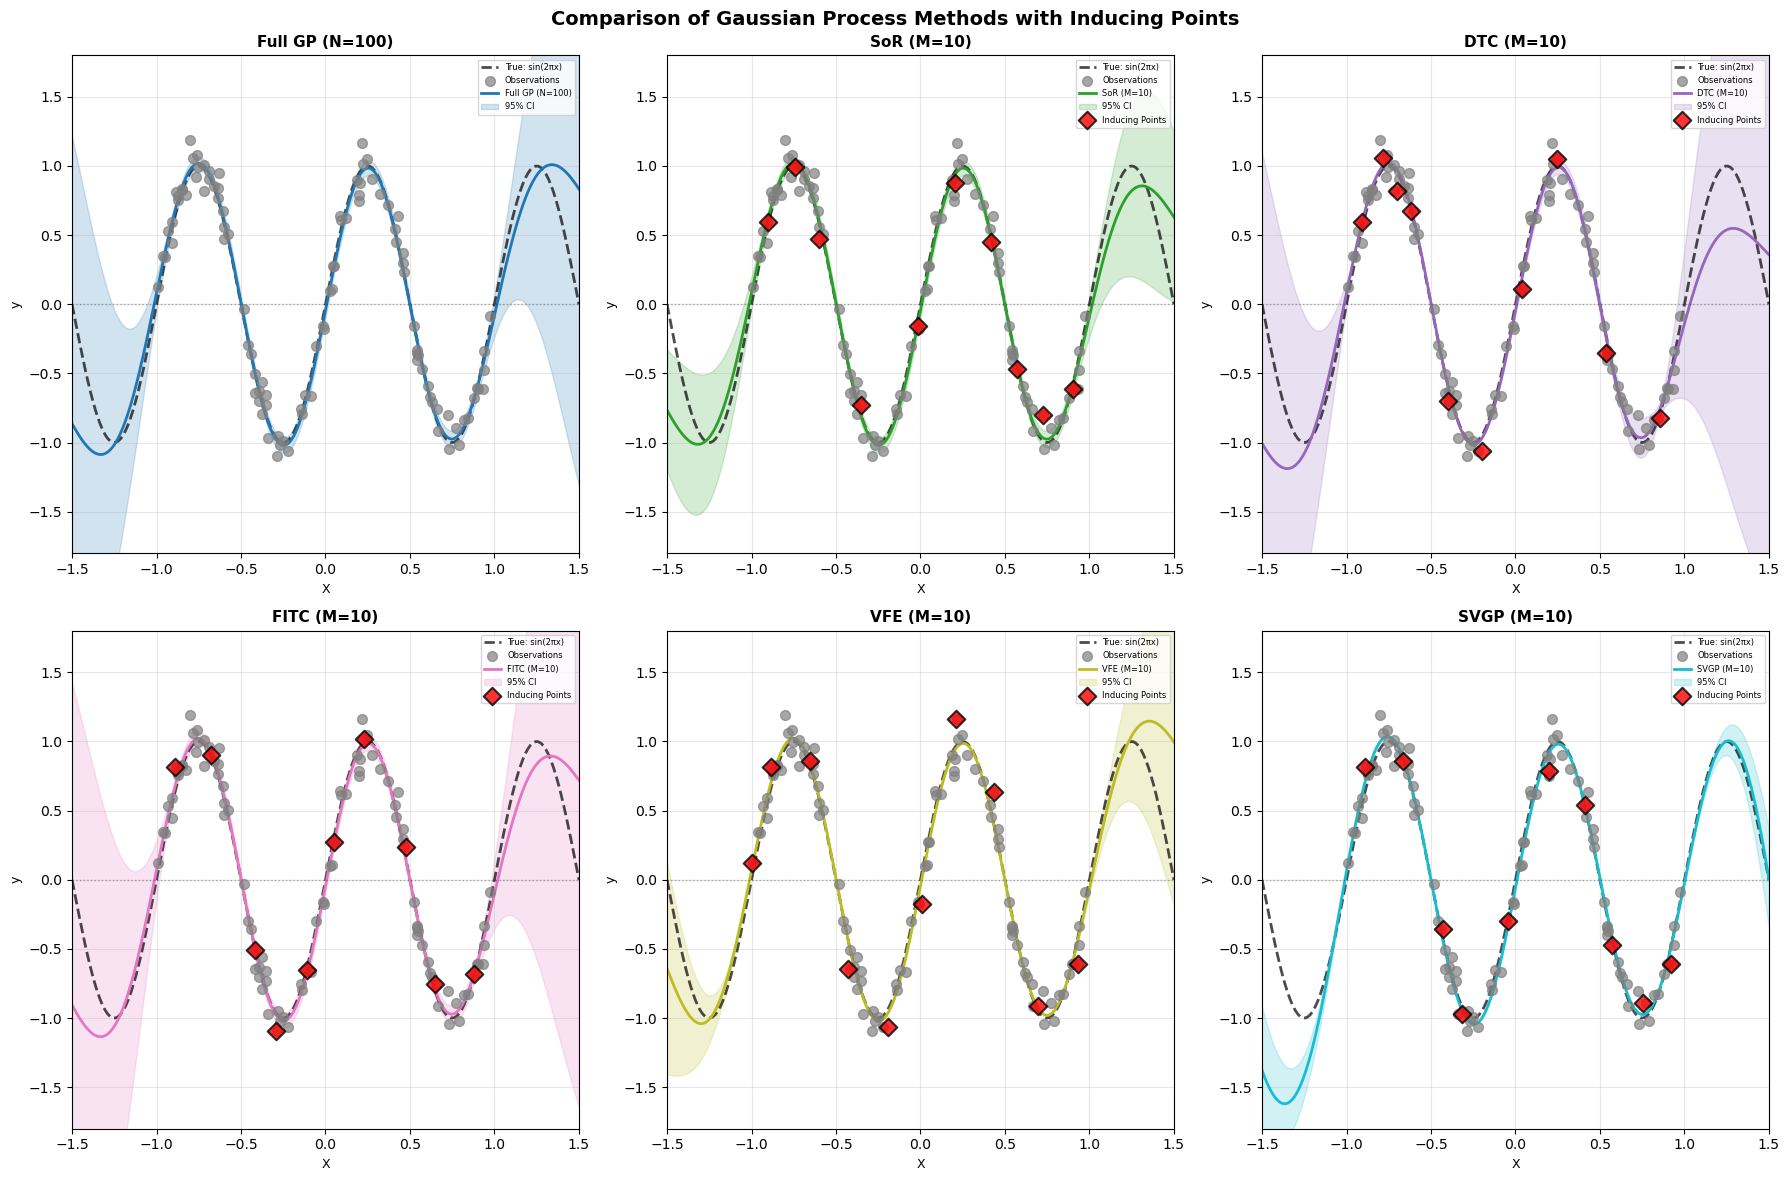

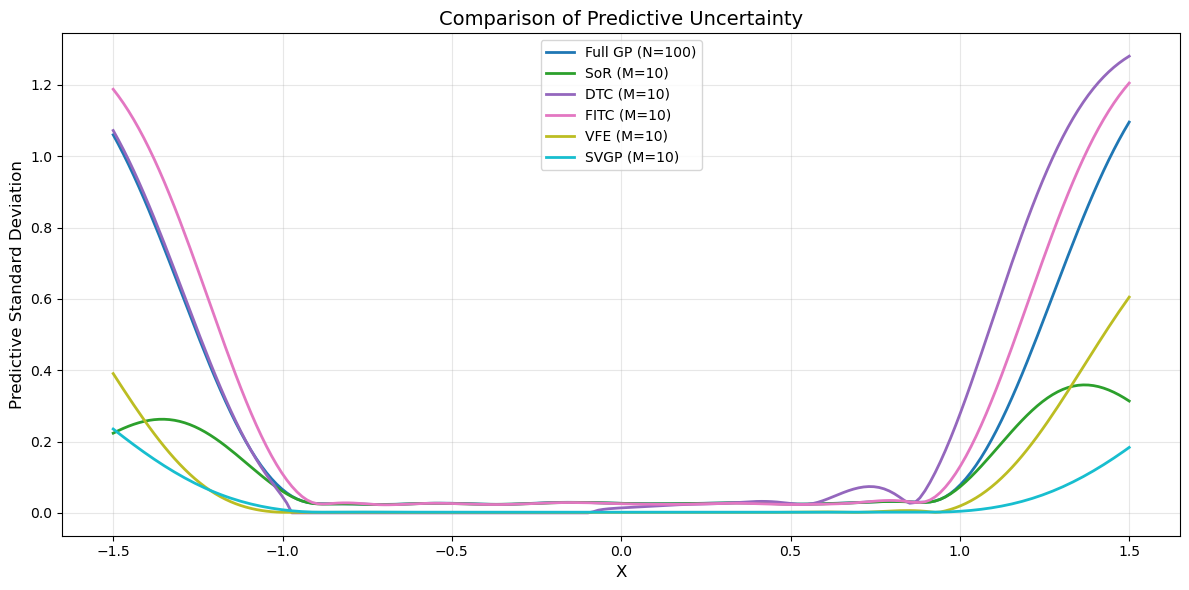

In [2]:
if __name__ == "__main__":
    np.random.seed(42)
    
    print("="*60)
    print("DEMONSTRATION: Gaussian Process Methods Comparison")
    print("="*60)
    
    X = np.random.uniform(-1, 1, 100).reshape(-1, 1)
    y = np.sin(2 * np.pi * X).ravel() + np.random.normal(0, 0.1, X.shape[0])
    
    X_pred = np.linspace(-1.5, 1.5, 200).reshape(-1, 1)  
    y_true = np.sin(2 * np.pi * X_pred).ravel()
    
    models = {
        'Full GP (N=100)': GaussianProcess(n_restarts_optimizer=3),
        'SoR (M=10)': SoRGP(n_restarts_optimizer=3, n_inducing=10),
        'DTC (M=10)': DTCGP(n_restarts_optimizer=3, n_inducing=10),
        'FITC (M=10)': FITCGP(n_restarts_optimizer=3, n_inducing=10),
        'VFE (M=10)': VFEWrapper(n_restarts_optimizer=3, n_inducing=10),
        'SVGP (M=10)': SVIGPWrapper(n_restarts_optimizer=3, n_inducing=10),
    }
    
    predictions = {}
    training_times = {}
    prediction_times = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        start_time = time.time()
        model.fit(X, y)
        training_time = time.time() - start_time
        training_times[name] = training_time
        #print(f"  Training time: {training_time:.2f} seconds")
    
        start_time = time.time()
        y_pred, y_std = model.predict(X_pred, return_std=True)
        prediction_time = time.time() - start_time
        prediction_times[name] = prediction_time
        predictions[name] = (y_pred, y_std)
        
        print(f"  Prediction time: {prediction_time:.2f} seconds")
        print(f"  Mean std: {y_std.mean():.4f}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    for idx, (name, (y_pred, y_std)) in enumerate(predictions.items()):
        if idx >= len(axes):  
            break
            
        ax = axes[idx]
        color = colors[idx]
        ax.plot(X_pred.ravel(), y_true, 'k--', linewidth=2.0, 
                label='True: sin(2πx)', alpha=0.7)
        ax.scatter(X, y, color='gray', s=50, label='Observations', zorder=5, alpha=0.7)
        
        ax.plot(X_pred.ravel(), y_pred, color=color, linewidth=2.0, 
                linestyle='-', label=f'{name}')
        
        ax.fill_between(
            X_pred.ravel(), 
            y_pred - 1.96 * y_std, 
            y_pred + 1.96 * y_std, 
            alpha=0.2, 
            color=color, 
            label='95% CI'
        )
        
        if hasattr(models[name], 'Z') and models[name].Z is not None:
            Z = models[name].Z
            if Z is not None and len(Z) > 0:
                if name in ['VFE (M=10)', 'SVGP (M=10)']:
                    xmean = models[name].model.xmean.numpy()
                    xstd = models[name].model.xstd.numpy()
                    Z_original = Z * xstd + xmean
                    y_z = []
                    for z in Z_original:
                        distances = np.abs(X.ravel() - z.ravel())
                        nearest_idx = np.argmin(distances)
                        y_z.append(y[nearest_idx])
                    y_z = np.array(y_z)
                    
                    ax.scatter(Z_original, y_z, color='red', s=80, marker='D', 
                              edgecolors='black', linewidth=1.5, 
                              label='Inducing Points', zorder=10, alpha=0.8)
                else:
                    y_z = []
                    for z in Z:
                        distances = np.abs(X.ravel() - z.ravel())
                        nearest_idx = np.argmin(distances)
                        y_z.append(y[nearest_idx])
                    y_z = np.array(y_z)
                    
                    ax.scatter(Z, y_z, color='red', s=80, marker='D', 
                              edgecolors='black', linewidth=1.5, 
                              label='Inducing Points', zorder=10, alpha=0.8)
        
        ax.axhline(y=0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.set_title(f'{name}', fontsize=11, fontweight='bold')
        ax.set_xlabel('X', fontsize=9)
        ax.set_ylabel('y', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.8, 1.8)
        ax.set_xlim(-1.5, 1.5)
        ax.legend(loc='upper right', fontsize=6)
    
    plt.suptitle('Comparison of Gaussian Process Methods with Inducing Points', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for idx, (name, (y_pred, y_std)) in enumerate(predictions.items()):
        color = colors[idx]
        plt.plot(X_pred.ravel(), y_std, label=f'{name}', 
                linewidth=2.0, color=color, linestyle='-')
    
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Predictive Standard Deviation', fontsize=12)
    plt.title('Comparison of Predictive Uncertainty', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

DEMONSTRATION: Gaussian Process Methods Comparison

Training Full GP (N=200)...
  Prediction time: 0.01 seconds
  Mean std: 0.1842

Training SoR (M=10)...
  Prediction time: 0.00 seconds
  Mean std: 0.0571

Training DTC (M=10)...
  Prediction time: 0.00 seconds
  Mean std: 0.2353

Training FITC (M=10)...
  Prediction time: 0.01 seconds
  Mean std: 0.2524

Training VFE (M=10)...


/home/hechu/anaconda3/envs/credit/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  Prediction time: 0.00 seconds
  Mean std: 0.0491

Training SVGP (M=10)...


/home/hechu/anaconda3/envs/credit/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  Prediction time: 0.00 seconds
  Mean std: 0.0271


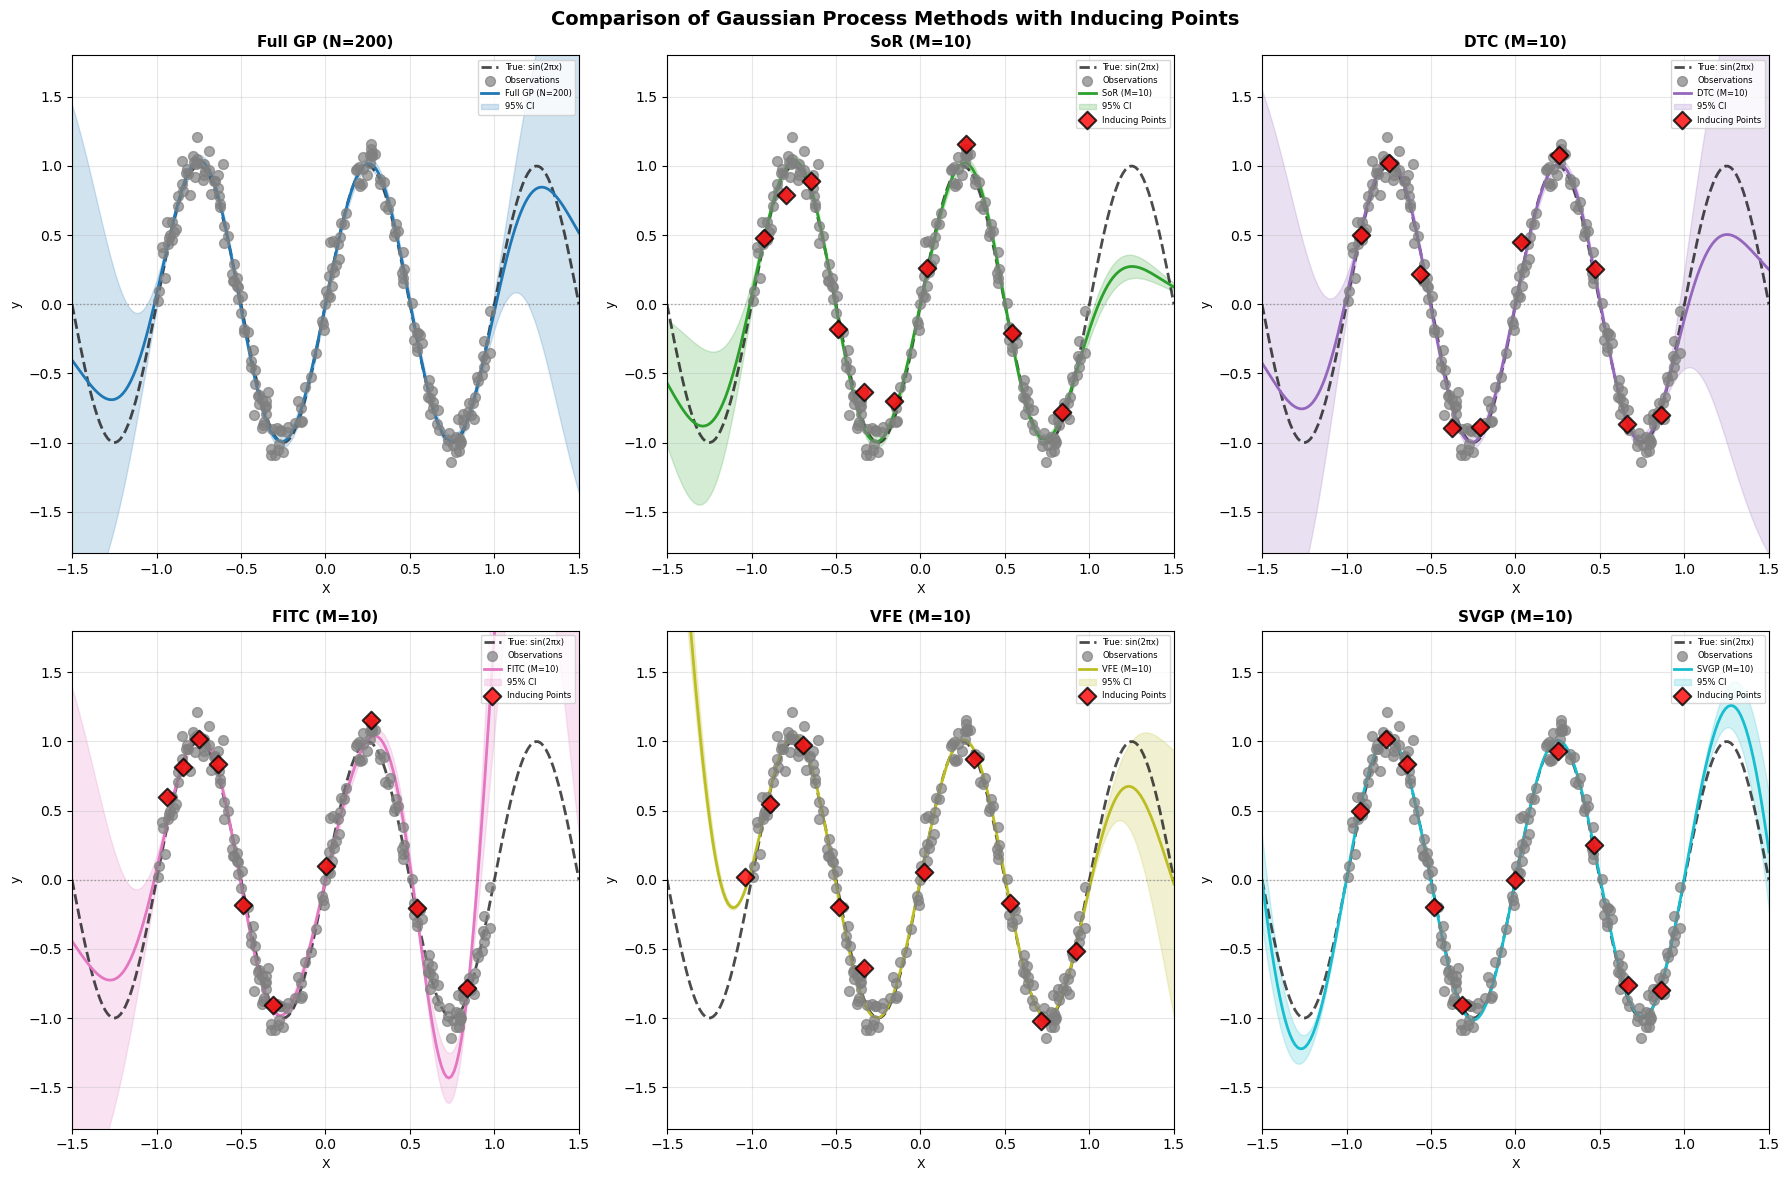

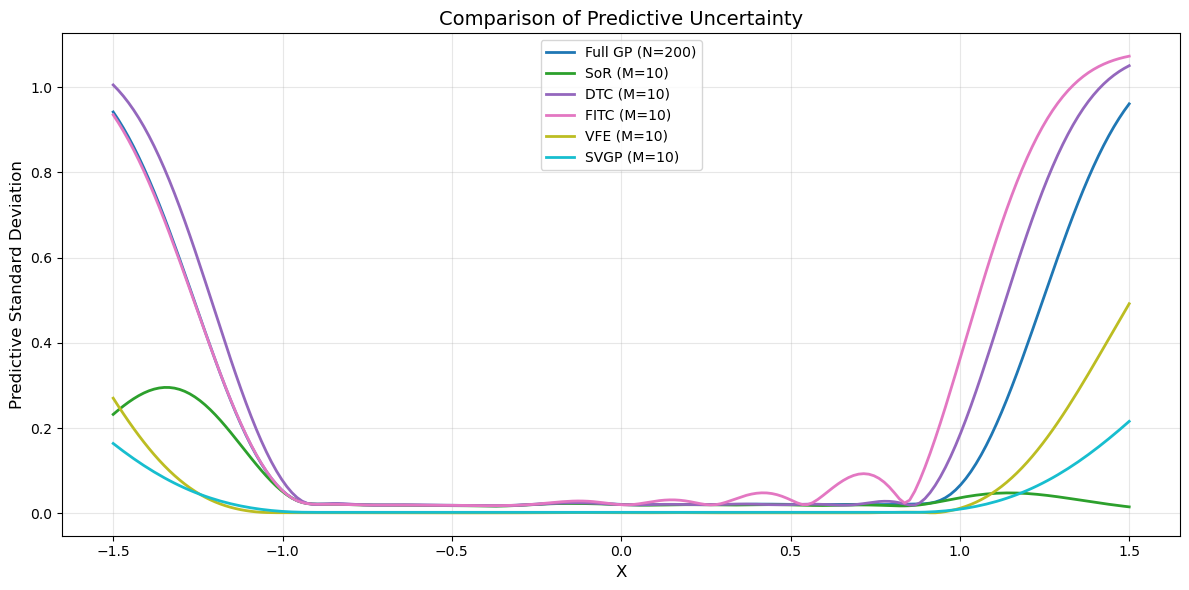

In [3]:
if __name__ == "__main__":
    np.random.seed(42)
    
    print("="*60)
    print("DEMONSTRATION: Gaussian Process Methods Comparison")
    print("="*60)
    
    X = np.random.uniform(-1, 1, 200).reshape(-1, 1)
    y = np.sin(2 * np.pi * X).ravel() + np.random.normal(0, 0.1, X.shape[0])
    
    X_pred = np.linspace(-1.5, 1.5, 200).reshape(-1, 1)  
    y_true = np.sin(2 * np.pi * X_pred).ravel()
    
    models = {
        'Full GP (N=200)': GaussianProcess(n_restarts_optimizer=3),
        'SoR (M=10)': SoRGP(n_restarts_optimizer=3, n_inducing=10),
        'DTC (M=10)': DTCGP(n_restarts_optimizer=3, n_inducing=10),
        'FITC (M=10)': FITCGP(n_restarts_optimizer=3, n_inducing=10),
        'VFE (M=10)': VFEWrapper(n_restarts_optimizer=3, n_inducing=10),
        'SVGP (M=10)': SVIGPWrapper(n_restarts_optimizer=3, n_inducing=10),
    }
    
    predictions = {}
    training_times = {}
    prediction_times = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        start_time = time.time()
        model.fit(X, y)
        training_time = time.time() - start_time
        training_times[name] = training_time
        #print(f"  Training time: {training_time:.2f} seconds")
    
        start_time = time.time()
        y_pred, y_std = model.predict(X_pred, return_std=True)
        prediction_time = time.time() - start_time
        prediction_times[name] = prediction_time
        predictions[name] = (y_pred, y_std)
        
        print(f"  Prediction time: {prediction_time:.2f} seconds")
        print(f"  Mean std: {y_std.mean():.4f}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    for idx, (name, (y_pred, y_std)) in enumerate(predictions.items()):
        if idx >= len(axes):  
            break
            
        ax = axes[idx]
        color = colors[idx]
        ax.plot(X_pred.ravel(), y_true, 'k--', linewidth=2.0, 
                label='True: sin(2πx)', alpha=0.7)
        ax.scatter(X, y, color='gray', s=50, label='Observations', zorder=5, alpha=0.7)
        
        ax.plot(X_pred.ravel(), y_pred, color=color, linewidth=2.0, 
                linestyle='-', label=f'{name}')
        
        ax.fill_between(
            X_pred.ravel(), 
            y_pred - 1.96 * y_std, 
            y_pred + 1.96 * y_std, 
            alpha=0.2, 
            color=color, 
            label='95% CI'
        )
        
        if hasattr(models[name], 'Z') and models[name].Z is not None:
            Z = models[name].Z
            if Z is not None and len(Z) > 0:
                if name in ['VFE (M=10)', 'SVGP (M=10)']:
                    xmean = models[name].model.xmean.numpy()
                    xstd = models[name].model.xstd.numpy()
                    Z_original = Z * xstd + xmean
                    y_z = []
                    for z in Z_original:
                        distances = np.abs(X.ravel() - z.ravel())
                        nearest_idx = np.argmin(distances)
                        y_z.append(y[nearest_idx])
                    y_z = np.array(y_z)
                    
                    ax.scatter(Z_original, y_z, color='red', s=80, marker='D', 
                              edgecolors='black', linewidth=1.5, 
                              label='Inducing Points', zorder=10, alpha=0.8)
                else:
                    y_z = []
                    for z in Z:
                        distances = np.abs(X.ravel() - z.ravel())
                        nearest_idx = np.argmin(distances)
                        y_z.append(y[nearest_idx])
                    y_z = np.array(y_z)
                    
                    ax.scatter(Z, y_z, color='red', s=80, marker='D', 
                              edgecolors='black', linewidth=1.5, 
                              label='Inducing Points', zorder=10, alpha=0.8)
        
        ax.axhline(y=0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.set_title(f'{name}', fontsize=11, fontweight='bold')
        ax.set_xlabel('X', fontsize=9)
        ax.set_ylabel('y', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.8, 1.8)
        ax.set_xlim(-1.5, 1.5)
        ax.legend(loc='upper right', fontsize=6)
    
    plt.suptitle('Comparison of Gaussian Process Methods with Inducing Points', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for idx, (name, (y_pred, y_std)) in enumerate(predictions.items()):
        color = colors[idx]
        plt.plot(X_pred.ravel(), y_std, label=f'{name}', 
                linewidth=2.0, color=color, linestyle='-')
    
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Predictive Standard Deviation', fontsize=12)
    plt.title('Comparison of Predictive Uncertainty', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Adjust font size

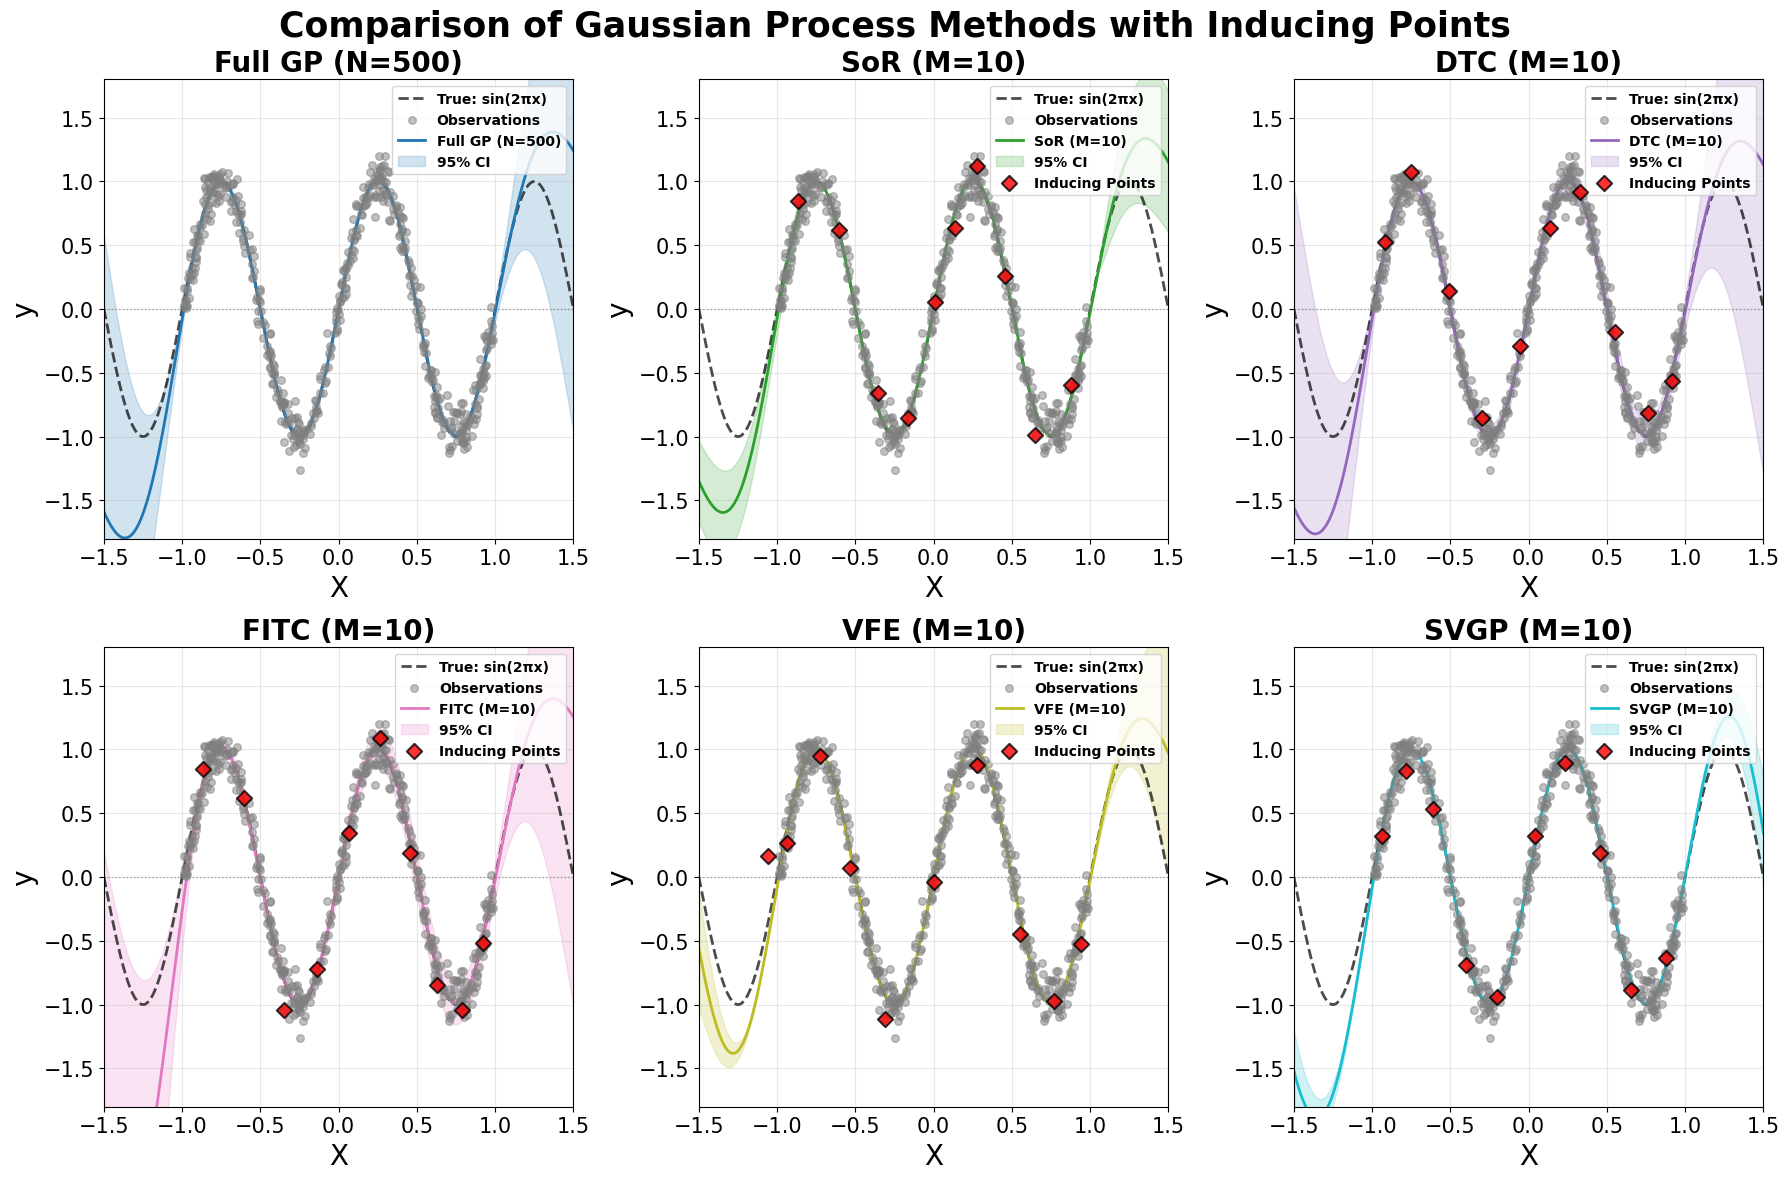

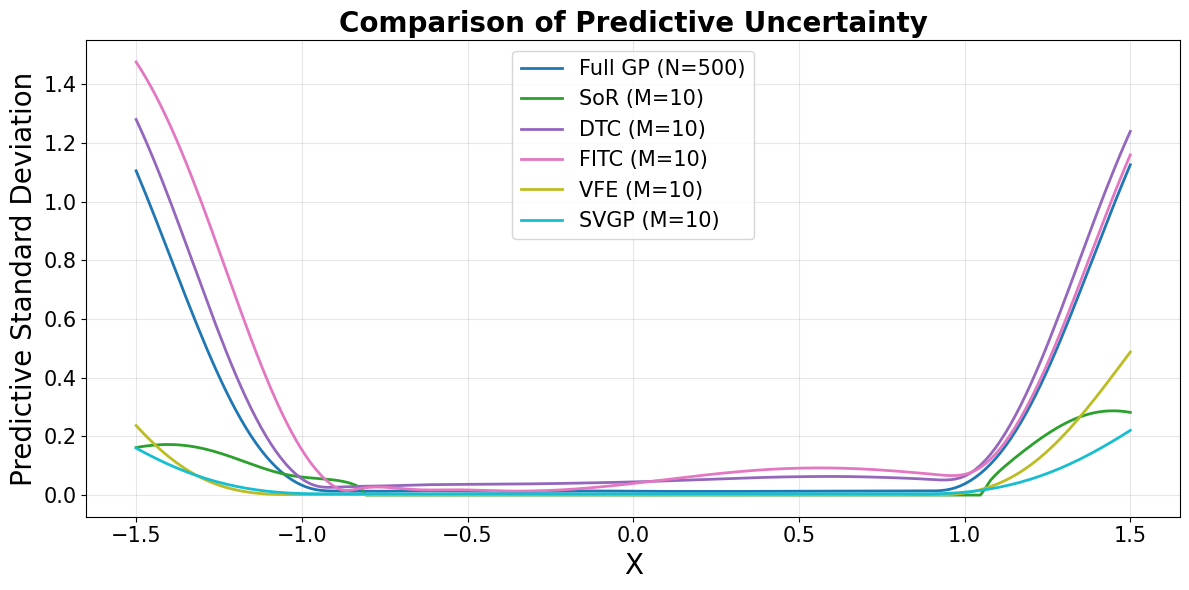

In [ ]:
if __name__ == "__main__":
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    for idx, (name, (y_pred, y_std)) in enumerate(predictions.items()):
        if idx >= len(axes):  
            break
            
        ax = axes[idx]
        color = colors[idx]
        ax.plot(X_pred.ravel(), y_true, 'k--', linewidth=2.0, 
                label='True: sin(2πx)', alpha=0.7)
        ax.scatter(X, y, color='gray', s=30, label='Observations', zorder=5, alpha=0.5)
        
        ax.plot(X_pred.ravel(), y_pred, color=color, linewidth=2.0, 
                linestyle='-', label=f'{name}')
        
        ax.fill_between(
            X_pred.ravel(), 
            y_pred - 1.96 * y_std, 
            y_pred + 1.96 * y_std, 
            alpha=0.2, 
            color=color, 
            label='95% CI'
        )
        
        if hasattr(models[name], 'Z') and models[name].Z is not None:
            Z = models[name].Z
            if Z is not None and len(Z) > 0:
                if name in ['VFE (M=10)', 'SVGP (M=10)']:
                    xmean = models[name].model.xmean.numpy()
                    xstd = models[name].model.xstd.numpy()
                    Z_original = Z * xstd + xmean
                    y_z = []
                    for z in Z_original:
                        distances = np.abs(X.ravel() - z.ravel())
                        nearest_idx = np.argmin(distances)
                        y_z.append(y[nearest_idx])
                    y_z = np.array(y_z)
                    
                    ax.scatter(Z_original, y_z, color='red', s=60, marker='D', 
                              edgecolors='black', linewidth=1.5, 
                              label='Inducing Points', zorder=10, alpha=0.8)
                else:
                    y_z = []
                    for z in Z:
                        distances = np.abs(X.ravel() - z.ravel())
                        nearest_idx = np.argmin(distances)
                        y_z.append(y[nearest_idx])
                    y_z = np.array(y_z)
                    
                    ax.scatter(Z, y_z, color='red', s=60, marker='D', 
                              edgecolors='black', linewidth=1.5, 
                              label='Inducing Points', zorder=10, alpha=0.8)
        
        ax.axhline(y=0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.set_title(f'{name}', fontsize=20, fontweight='bold')
        ax.set_xlabel('X', fontsize=20)
        ax.set_ylabel('y', fontsize=20)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.8, 1.8)
        ax.set_xlim(-1.5, 1.5)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(loc='upper right', prop={'size': 10, 'weight': 'bold'})
    
    plt.suptitle('Comparison of Gaussian Process Methods with Inducing Points', 
                 fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for idx, (name, (y_pred, y_std)) in enumerate(predictions.items()):
        color = colors[idx]
        plt.plot(X_pred.ravel(), y_std, label=f'{name}', 
                linewidth=2.0, color=color, linestyle='-')
    
    plt.xlabel('X', fontsize=20)
    plt.ylabel('Predictive Standard Deviation', fontsize=20)
    plt.title('Comparison of Predictive Uncertainty', fontsize=20, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(prop={'size': 15})
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()
    plt.show()

In [2]:
for name, model in models.items():
        print(f"  Training time: {training_times[name]:.2f} seconds")

  Training time: 652.41 seconds
  Training time: 855.05 seconds
  Training time: 729.06 seconds
  Training time: 846.91 seconds
  Training time: 0.62 seconds
  Training time: 1.68 seconds
